# Importing libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score
import pickle
import os.path
import plotly.offline as pyo
import plotly.graph_objs as go
import spacy
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#

# Context

MBTI (Myers-Briggs Type Indicator) is an introspective self-report questionnaire indicating differing psychological preferences (cognitive functions) in how people perceive the world and make decisions

This study was made based on the kaggle dataset https://www.kaggle.com/zeyadkhalid/mbti-personality-types-500-dataset

# Stop words

As said, this dataset doesn't has any stop words

"Stop words" are words that appears so frequently that don't require tagging as thoroughly as nouns, verbs and modifiers

Let's use the library Spacy to see examples of english stop words

Spacy is the Industrial Strength Natural Language Processing: https://spacy.io/

In [3]:
# Load one of the availables trained pipelines for English
# English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
nlp = spacy.load('en_core_web_sm')


# stop words built in spacy (english)
print(nlp.Defaults.stop_words)

{'fifteen', 'it', 'two', 'many', 'made', 'our', 'until', 'bottom', 'your', 'except', 'last', 'up', 'side', 'becomes', 'well', 'should', 'she', 'just', 'when', 'much', 'what', 'hence', 'more', 'again', 'her', '‘ll', 'most', 'in', 'always', 'how', 'by', 'either', 'to', 'whom', 'whenever', 'may', 'can', 'over', 'neither', 'namely', 'amongst', 'meanwhile', 'whereas', 'mine', 'whatever', 'very', 'they', 'one', 'anything', 'them', 'n’t', 'him', 'please', 'myself', "'ve", 'why', 'behind', 'some', 'alone', 'such', 'as', 'other', 'us', 'ca', 'are', 'already', 'rather', 'being', 'so', 'cannot', "'s", 'once', 'i', 'everything', 'yourself', 'for', 'less', 'latter', 'perhaps', 'often', 'noone', '‘m', 'seems', 'somehow', 'eight', 'thereafter', 'moreover', 'something', 'whoever', 'therein', 'herein', 'n‘t', 'been', 'a', 'has', 'unless', 'afterwards', 'quite', 'thereby', 'various', 'whose', 'between', 'nine', 'elsewhere', 'than', 'and', 'twelve', 'ten', '‘d', 'he', 'nobody', 'enough', '’m', 'per', 'he

In [4]:
print(f"Number of default stop words : {len(nlp.Defaults.stop_words)}")

Number of default stop words : 326


In [5]:
# Checking if a word is a stop word
nlp.vocab['is'].is_stop

True

In [6]:
nlp.vocab['below'].is_stop

True

In [7]:
nlp.vocab['btw'].is_stop

False

# Lemmatization

As said before, this dataset also has Lemmatization preprocess feature

In order to understand lemmatization, first we'll look at the concept of Stemming

### Stemming

Stemming is used to return similarities words on the search process. 
 
 - Example: search=boat, also returns "boats" and "boating"

Let's use a sophisticated stemmer, the SnowballStemmer from NLTK (natural language toolkit)

In [8]:
s_stemmer = SnowballStemmer(language='english')

In [9]:
words = ['run', 'runner', 'ran', 'runs', 'easily', 'fairly', 'fairness','boats','boating']

In [10]:
for word in words:
    print(word+ ' ------> ' + s_stemmer.stem(word))

run ------> run
runner ------> runner
ran ------> ran
runs ------> run
easily ------> easili
fairly ------> fair
fairness ------> fair
boats ------> boat
boating ------> boat


Now, let's look about Lemmatization

### Lemmatization example

In constrast with stemming, Lemmatization looks beyond word reduction, and considers a language's full vocabulary to apply a morphological analysis to words.

In [11]:
# Function to display lemmas
def show_lemmas(text):
    for token in text:
        print(f'{token.text:{12}} {token.pos_:{6}} {token.lemma:<{22}} {token.lemma_}')

In [12]:
doc = nlp(u"I saw eighteen mice today!")
show_lemmas(doc)

I            PRON   4690420944186131903    I
saw          VERB   11925638236994514241   see
eighteen     NUM    9609336664675087640    eighteen
mice         NOUN   1384165645700560590    mouse
today        NOUN   11042482332948150395   today
!            PUNCT  17494803046312582752   !


In [13]:
doc = nlp(u"I am meeting him tomorrow at the meeting.")
show_lemmas(doc)

I            PRON   4690420944186131903    I
am           AUX    10382539506755952630   be
meeting      VERB   6880656908171229526    meet
him          PRON   1655312771067108281    he
tomorrow     NOUN   3573583789758258062    tomorrow
at           ADP    11667289587015813222   at
the          DET    7425985699627899538    the
meeting      NOUN   14798207169164081740   meeting
.            PUNCT  12646065887601541794   .


Now it's time to talk about Text Feature Extraction

# Text Feature Extraction

After preprocess data it's time to extract features from the text in order to prepare the machine learning model

In [14]:
count_vect = CountVectorizer()

In [15]:
phrase = ["I'd like to have a glass of water please"]

In [16]:
# Fit Vectorizer to the Data (build a vocab, count the number of words...)
# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(phrase)

CountVectorizer()

In [17]:
# Show features
count_vect.get_feature_names()

['glass', 'have', 'like', 'of', 'please', 'to', 'water']

In [18]:
# Learn the vocabulary dictionary and return document-term matrix
count_vect.fit_transform(phrase)

<1x7 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [19]:
# shows a mapping of terms to feature indices.
count_vect.vocabulary_

{'like': 2, 'to': 5, 'have': 1, 'glass': 0, 'of': 3, 'water': 6, 'please': 4}

## TfidVectorizer

An alternative to CountVectorizer is the TfidVectorizer

TfidVectorizer calculates an inverse frequency for each word

# Read the dataset into a pandas dataframe

Now it's time to read the dataset and make a simple exploratory analysis

In [20]:
df = pd.read_csv('/kaggle/input/mbti-personality-types-500-dataset/MBTI 500.csv')

In [21]:
df.head()

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ


In [22]:
df['posts'][0]

'know intj tool use interaction people excuse antisocial truly enlighten mastermind know would count pet peeze something time matter people either whether group people mall never see best friend sit outside conversation jsut listen want interject sit formulate say wait inject argument thought find fascinate sit watch people talk people fascinate sit class watch different people find intrigue dad intj u stand look like line safeway watch people home talk people like think military job people voluntarily go job important show deference endanger live glorify way civilian think pretty ignorant general think military necessary defense mechanism political tactic feel like u specifically invest much money could put money education whatnot though personally sound budget aernative really comment one way base two politician eye year ago come name somewhat important kinda role model nowadays pick keep score individual level mean little vary accord number condition day may score high others low sw

In [23]:
df['type'][0]

'INTJ'

In [24]:
df['type'].unique()

array(['INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
       'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ', 'INFP'],
      dtype=object)

In [25]:
df['type'][2]

'INTJ'

In [26]:
print(f"Total of {len(df['type'].unique())} types of classified MBTI posts")

Total of 16 types of classified MBTI posts


# Checking null values

In [27]:
df.isnull().sum()

posts    0
type     0
dtype: int64

# Checking the number of posts per type

In [28]:
df_bar_chart=df.groupby('type').count()


trace1 = go.Bar(x=df_bar_chart.index, y=df_bar_chart['posts'])

data = [trace1]
layout = go.Layout(title='MBTI # Classified Posts per Type')

fig = go.Figure(data=data, layout=layout)

fig.show()

# Recreate the model?

This machine learning model takes it's time to train data

To avoid waiting every time, We're going to use the feature dump/load from pickle

In [29]:
# Flag to re-create or not the machine learning model
recreate_model=False

In [30]:
# We'll save the model into a file:
filename = 'mbti_svm_v2.sav'

In [31]:
# If the model file doesn't exists
if not os.path.isfile(filename):
    recreate_model=True

# Split the data into train and test

In [32]:
X = df['posts'] # features
y = df['type']  # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch
from torch import nn, optim

# Assuming you have 'transformers' library installed, if not, you can install it using: pip install transformers

# Combine both training and testing labels for encoding
all_labels = y_train.append(y_test)

# Encode the labels
label_encoder = LabelEncoder()

# Fit and transform on the combined set of labels
all_labels_encoded = label_encoder.fit_transform(all_labels)

# Split the encoded labels back into training and testing sets
y_train_encoded = all_labels_encoded[:len(y_train)]
y_test_encoded = all_labels_encoded[len(y_train):]

# Tokenizing the input text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenizing and encoding the training data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Converting the data into PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(y_train_encoded))  # use the encoded labels

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test_encoded))  # use the encoded labels

# ... (rest of the code remains the same)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [65]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Save the label encoder to a file
joblib.dump(label_encoder, 'label_encoder.joblib')


['label_encoder.joblib']

In [34]:
Save the datasets
torch.save(train_dataset, 'train_dataset.pth')
torch.save(test_dataset, 'test_dataset.pth')

# Load the datasets
# train_dataset = torch.load('/kaggle/input/dataloader/train_dataset.pth')
# test_dataset = torch.load('/kaggle/input/dataloader/test_dataset.pth')


In [35]:
from transformers import BertTokenizer

Save the tokenizer
tokenizer.save_pretrained('tokenizer')

# Now you can use loaded_tokenizer in your code
# tokenizer = BertTokenizer.from_pretrained('/kaggle/input/tokenizer')


In [36]:
from transformers import BertTokenizer, BertForSequenceClassification

# Defining the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [37]:
# torch.cuda.empty_cache()
# torch.cuda.empty()


In [ ]:

# Defining the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['type'].unique()))

# Defining the DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Defining the optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [42]:
from torch.cuda.amp import autocast, GradScaler
from transformers import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)
scaler = GradScaler()

# Training loop
epochs = 5
accumulation_steps = 4  # Adjust as needed
batch_idx = 0  # Initialize batch index

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        optimizer.zero_grad()

        with autocast():
            outputs = model(**inputs)
            loss = outputs.loss

        scaler.scale(loss).backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

        # Calculate accuracy
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == inputs['labels']).sum().item()
        total_samples += inputs['labels'].size(0)

        batch_idx += 1  # Increment batch index

    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100

    print(f'Epoch {epoch + 1}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Learning rate scheduler
    scheduler.step(average_loss)


Epoch 1: 100%|██████████| 10607/10607 [58:18<00:00,  3.03it/s]


Epoch 1, Average Loss: 1.0514, Accuracy: 68.26%


Epoch 2: 100%|██████████| 10607/10607 [58:05<00:00,  3.04it/s]


Epoch 2, Average Loss: 0.7746, Accuracy: 76.31%


Epoch 3: 100%|██████████| 10607/10607 [58:00<00:00,  3.05it/s]


Epoch 3, Average Loss: 0.6868, Accuracy: 78.93%


Epoch 4: 100%|██████████| 10607/10607 [58:00<00:00,  3.05it/s]


Epoch 4, Average Loss: 0.6253, Accuracy: 80.92%


Epoch 5: 100%|██████████| 10607/10607 [57:56<00:00,  3.05it/s]

Epoch 5, Average Loss: 0.5743, Accuracy: 82.44%


In [45]:
# Save the trained model
torch.save(model.state_dict(), 'mbti-model.pth')

In [46]:
torch.save(model, 'mbti-model-complete.pth')


In [ ]:

# Evaluating the model
model.eval()

In [51]:

correct = 0
total = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        outputs = model(**inputs)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        total += inputs['labels'].size(0)
        correct += (predicted == inputs['labels']).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Evaluating: 100%|██████████| 2652/2652 [11:59<00:00,  3.68it/s]

Test Accuracy: 81.71%


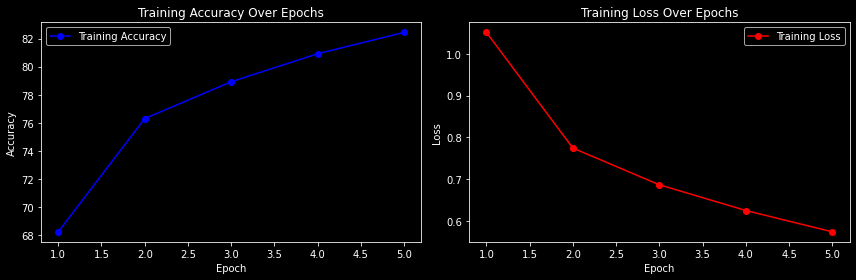

In [52]:
import matplotlib.pyplot as plt

# Replace these with your actual accuracy and loss values
epoch_numbers = [1, 2, 3, 4, 5]
train_accuracies = [68.26, 76.31, 78.93, 80.92, 82.44]
train_losses = [1.0514, 0.7746, 0.6868, 0.6253, 0.5743]

# Use a dark theme
plt.style.use('dark_background')

# Plotting
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epoch_numbers, train_accuracies, marker='o', linestyle='-', color='b', label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epoch_numbers, train_losses, marker='o', linestyle='-', color='r', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [50]:
df['type'][2], df['posts'][2]

('INTJ',
 'preferably p hd low except wew lad video p mind good reason agree statement relationship become difficu maintain people involve different stag life constantly feel though feign certain emotion counteract natural appearance aloofness excite someone engagement welcome someone bring child office internally really care either thing order mesh generally e office one strategically fake make act like thing matter family use phase anymore naturally open almost difficu fake around one occasion year feel obligate feign emotion actually comfortable around people overcome social anxiety fake emotion appear le detach completely different former take time persistent effort latter patch gauze cover wind former live fake learn comfort zone socially embrace people accept effort easily sniff counterfeit sense would take plenty vitamin get sunlight eat good visit r watchpeopledie appreciate life remember achieve thus far say intj resu trauma student study nurse something find interest body lan

In [64]:
df['type'][4000], df['posts'][4000]

('INTJ',
 'u theagame say big problem people cannot comprehend see point problem arise thankfully really good mentor allow make mistake full production cycle show area improve say also show efficient way process volume data deal example change underlie query significantly improve speed one many process use take hour take minute honestly anything leverage intjs system style think ability see interconnection say system good thing cannot control well people work exactly like sculptor michelangelo begrudgingly take job family paint church ceiling machiavelli resume portfolio snide tongue cheek page turner amuse mass give birth political science ummm really plan think would address please hug touch stop use word already use word word help far use useless enfp go doubt sincerity word shut authenticity one key aspect intjs enfps authenticity fi style feel fe style human use jungian function enfps use fi nd spot thus primal aspect intjs fi user rd spot thus primal hide primal aspect call poker

In [61]:
df['type'][50000], df['posts'][50000]

('ISTJ',
 'work lol thank ok istj however love swing f erratically however intrapersonal intelligence test show also describe n allmost tick everything however lot go head also however like explore f side thus give ability cry want need need release nearly cry private yes agree could make comment yet cant personal divulge intrested true friend post email find enfj forgive however happen would much hatred yes agree opersites facinating chance feel person hold istj build ideal moral grow personality hehehe know patience stick someone try force thing change realy pee mind im one beleive need someone little real life maybe past month get hour socialise op comment agree enough feel waste day life go im go say owiee head hurt agree istj enfp good istj keep much hide bottle sure let thing need good proportion time tell people thing skim around edge first cant afford second want linux mac window vista guess speak many istj problem change nsure leave alone like grey bug live load time seriously

In [60]:
df['type'][30000], df['posts'][30000]

('INTP',
 'need exactly le likely know mean mean intp extremely difficu time force maintenance type task clean apartment exercise thing nature find help little bite tackle small bit example half dish go something else little bite come back finish know help think necessarily put danger thing specifically fearful maybe need take experience extreme depend im really like picasso van gogh thing like like film character concept art landscape art fictional city like sometimes write use write lot fiction kid like see people creativity especially way literally see need much knowledge understand something creative sense im car person bc get part work really problem fi value make logical sense system ti even relation least discern ti tert well course say ti inherent mean value anything beside mechanical theoretical function curiosity work mean system reference logical within relation accurate le unless new information present everything reassess reposition correlate new data corrective function w

In [63]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load tokenizer from directory
tokenizer = BertTokenizer.from_pretrained('/kaggle/input/tokenizer')

# Load the saved complete model
model = torch.load('/kaggle/working/mbti-model-complete.pth')

# Set the device (either 'cuda' for GPU or 'cpu' for CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move the model to the same device as the input data
model.to(device)

def predict_class(input_text):
    # Tokenize and encode the input text
    input_ids = tokenizer.encode(input_text, add_special_tokens=True, max_length=512, truncation=True, return_tensors='pt')

    # Move the input data to the same device as the model
    input_ids = input_ids.to(device)

    # Make the prediction
    with torch.no_grad():
        model.eval()
        logits = model(input_ids)[0]

    # Get the predicted class
    predicted_class = torch.argmax(logits).item()

    return predicted_class


while True:
    # Take user input
    print(f"\n***********************************************\n")
   
    user_input = input("Enter a post (type 'exit' to quit): ")

    # Check if the user wants to exit
    if user_input.lower() == 'exit':
        break

    # Tokenize and encode the input text
    input_ids = tokenizer.encode(user_input, add_special_tokens=True, max_length=512, truncation=True, return_tensors='pt')

    # Move the input data to the same device as the model
    input_ids = input_ids.to(device)

    # Make the prediction
    with torch.no_grad():
        model.eval()
        logits = model(input_ids)[0]

    # Get the predicted class
    predicted_class = torch.argmax(logits).item()

    # Decode the predicted class using the label encoder
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    print(f"\nPredicted Personality Type: {predicted_label}")
    print(f"\n***********************************************\n")
    


***********************************************



Enter a post (type 'exit' to quit):  need exactly le likely know mean mean intp extremely difficu time force maintenance type task clean apartment exercise thing nature find help little bite tackle small bit example half dish go something else little bite come back finish know help think necessarily put danger thing specifically fearful maybe need take experience extreme depend im really like picasso van gogh thing like like film character concept art landscape art fictional city like sometimes write use write lot fiction kid like see people creativity especially way literally see need much knowledge understand something creative sense im car person bc get part work really problem fi value make logical sense system ti even relation least discern ti tert well course say ti inherent mean value anything beside mechanical theoretical function curiosity work mean system reference logical within relation accurate le unless new information present everything reassess reposition correlate new 


Predicted Personality Type: INTP

***********************************************


***********************************************



Enter a post (type 'exit' to quit):  work lol thank ok istj however love swing f erratically however intrapersonal intelligence test show also describe n allmost tick everything however lot go head also however like explore f side thus give ability cry want need need release nearly cry private yes agree could make comment yet cant personal divulge intrested true friend post email find enfj forgive however happen would much hatred yes agree opersites facinating chance feel person hold istj build ideal moral grow personality hehehe know patience stick someone try force thing change realy pee mind im one beleive need someone little real life maybe past month get hour socialise op comment agree enough feel waste day life go im go say owiee head hurt agree istj enfp good istj keep much hide bottle sure let thing need good proportion time tell people thing skim around edge first cant afford second want linux mac window vista guess speak many istj problem change nsure leave alone like grey bu


Predicted Personality Type: ISTJ

***********************************************


***********************************************



Enter a post (type 'exit' to quit):  drink like wish could drink red wine give headache almost instantaneously apparently people really sensitive byproduct red wine esfp bite place blissful go flow state change anything brother middle right thread really help realize need change honestly assume op know try make funny post even giggle also wonder would downvote guy people get mad get joke really know suppose one minority social recluse would quite sad buddhist strong humanist lean particularly see much geographical difference two hate sleep waste time hard stop think enough brain turn jesus christ close home every weeknight conversation wife believe men attract status way believe get degree somehow ensure end guy least much education status thing false agree false disagree woman know good woman want men high status feel like unfair smv increase status standard keep get high value stay woman good grip reality social interaction smv like reality like complain motivation go college first p


Predicted Personality Type: INTP

***********************************************


***********************************************



Enter a post (type 'exit' to quit):  preferably p hd low except wew lad video p mind good reason agree statement relationship become difficu maintain people involve different stag life constantly feel though feign certain emotion counteract natural appearance aloofness excite someone engagement welcome someone bring child office internally really care either thing order mesh generally e office one strategically fake make act like thing matter family use phase anymore naturally open almost difficu fake around one occasion year feel obligate feign emotion actually comfortable around people overcome social anxiety fake emotion appear le detach completely different former take time persistent effort latter patch gauze cover wind former live fake learn comfort zone socially embrace people accept effort easily sniff counterfeit sense would take plenty vitamin get sunlight eat good visit r watchpeopledie appreciate life remember achieve thus far say intj resu trauma student study nurse someth


Predicted Personality Type: INTJ

***********************************************


***********************************************



Enter a post (type 'exit' to quit):  exit
